In [1]:
# the aim is to end up with train, test, evaluate
import sys
sys.path.append("/Users/david/Documents/code/fhmm/v1")

In [2]:
import src.ads_davidjames9610.ads as ads
import src.ads_davidjames9610.useful as useful
import numpy as np
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from importlib import reload
import importlib
import src.classifiers_davidjames9610.test_a.config as base_config
reload(base_config)
config = importlib.import_module('src.classifiers_davidjames9610.test_a.whale_data.config')
reload(config)
print(config.basedir)
import src.misc_davidjames9610.fe_methods as fe
import src.misc_davidjames9610.proc_methods as pm

/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/whale_data


In [3]:
import src.misc_davidjames9610.utils as utils
sls = utils.load_pickle(config.samples_labels)

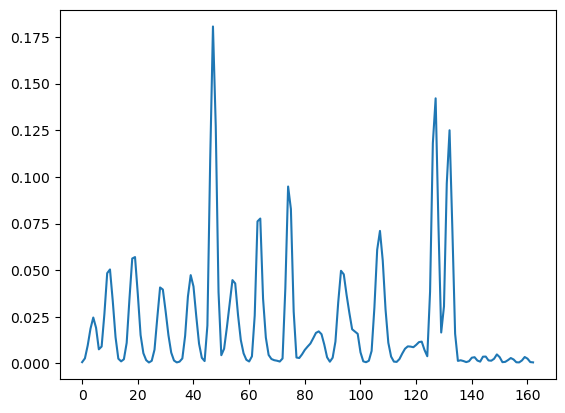

0.021640614193434177
0.01070885235949948


In [4]:
# going to have to do fe after cross-validation split
import src.misc_davidjames9610.cross_validation as cv
from src.misc_davidjames9610.cross_validation import *
import importlib
importlib.reload(cv)
from src.classifiers_davidjames9610.test_a import b_samples_to_features as feat_proc
reload(feat_proc)
import src.misc_davidjames9610.noisey as noisey
reload(noisey)
import random

# define config things
n_folds = 2
# could update this later if needed for more / less test data...
cv_output = cv.split_data_for_cross_validation(sls['samples'], sls['labels'], n_folds, test_ratio=0) # , test_ratio=0.8) # could update test ratio to
signal_average_power = feat_proc.get_average_power_for_samples(cv_output)
signal_average_power_v2 = np.square(np.linalg.norm(np.concatenate(cv_output['train_data'][0]), ord=2)) / len(np.concatenate(cv_output['train_data'][0]))
signal_average_power_db = 10 * np.log10(signal_average_power)
max_sample_length = np.max([len(sample) for sample in sls['samples']])
print(signal_average_power)
print(signal_average_power_v2)

In [5]:
# define noise addition, very low since validation data is practically 'clean'

snr = 60
nfft = 128

proc_method = feat_proc.ProcessingRealNoise(
        fe_method=fe.FeatureExtractorLogPower(nfft=nfft),
        snr=snr,
        signal_power=signal_average_power_db,
        sample_len=max_sample_length,
        noise_key='UNDER_WATER_DRONE'
        )
print("'" + proc_method.__str__() + "',")


completed ProcessingRealNoise
'lp_RealNoise_UNDER_WATER_DRONE_SNR60',


In [6]:
# create test data...

reload(fe)

features = {
}

fe_name = proc_method.__str__()
features[fe_name] = {}
print('processing for: ', fe_name)
n_folds = 1 # len(cv_output['train_data'])

# train
train_features = []
train_labels = []
for i in range(n_folds):
        curr_features = []
        curr_labels = []

        for sample_i in range(len(cv_output['train_data'][i])):
            sample = cv_output['train_data'][i][sample_i]
            curr_label = cv_output['train_label'][i][sample_i]
            try: # 65
                curr_feature = proc_method.pre_process(sample)
                if curr_feature.shape[0] > 1:
                    curr_features.append(curr_feature)
                    curr_labels.append(curr_label)
                else: print('sample to short at index', sample_i)
            except:
                print('sample to short at index', sample_i)

        train_features.append(curr_features)
        train_labels.append(curr_labels)

features[fe_name]['train_features'] = train_features
features[fe_name]['train_label'] = train_labels


processing for:  lp_RealNoise_UNDER_WATER_DRONE_SNR60


In [7]:
from src.classifiers_davidjames9610.test_a.b_samples_to_features import get_real_noise_sample

# this is where we make the test signal, how long is it ?

# length of real noise
noise_sample = get_real_noise_sample(
            noise_key=base_config.noise_sound_lib['UNDER_WATER_DRONE'], target_snr_db=0, signal_db=signal_average_power,
            sample_len=100, sr=config.sr)

# len of validation samples concat together
val_concat = (np.concatenate([sample for sample in cv_output['val_data'][0]]))

# I don't want noise in the validation data, we have noise which will be added.

In [82]:
val_data = cv_output['val_data'][0]
val_label = list(cv_output['val_label'][0])
indices = list(range(len(val_label)))
random.shuffle(indices)

val_data = [val_data[i] for i in indices]
val_label = np.array([val_label[i] for i in indices])

noise_sample_a = get_real_noise_sample(
            noise_key=base_config.noise_sound_lib['UNDER_WATER_DRONE'], target_snr_db=40, signal_db=0.015,
            sample_len=100, sr=config.sr)

noise_sample_b = get_real_noise_sample(
            noise_key=base_config.noise_sound_lib['UNDER_WATER_DRONE'], target_snr_db=20, signal_db=0.015,
            sample_len=100, sr=config.sr)


In [83]:
test_features = []
test_labels = []
val_label_mask = [label != sls['label_to_num']['NOISE'] for label in val_label]
val_label_filtered = val_label[val_label_mask]
val_data_filtered = [item for item, keep in zip(val_data, val_label_mask) if keep]
len_val_data = len(val_data_filtered)
time_domain_at_once = []

for i in range(len_val_data):
    noise_sample = noise_sample_a

    if i == len_val_data // 2:
        # add longer stretch of noise
        noise_len = np.random.randint(5000,10000)
        time_domain_sample = noise_sample_b[:noise_len]
        time_domain_at_once.extend(time_domain_sample)
        feature = proc_method.pre_process(time_domain_sample)
        if feature.ndim > 1:
            test_features.append(feature)
            test_labels.append(np.ones(len(feature)) * sls['label_to_num']['NOISE'])
        else: print('sample to short at index', i)
    if i >= len_val_data // 2:
        noise_sample = noise_sample_b
    # noise
    noise_len = np.random.randint(1000,5000)
    time_domain_sample = noise_sample[:noise_len]
    time_domain_at_once.extend(time_domain_sample)
    feature = proc_method.pre_process(time_domain_sample)
    if feature.ndim > 1:
        test_features.append(feature)
        test_labels.append(np.ones(len(feature)) * sls['label_to_num']['NOISE'])
    else: print('sample to short at index', i)

    # sample
    time_domain_sample = val_data_filtered[i] + noise_sample[:len(val_data_filtered[i])]
    time_domain_at_once.extend(time_domain_sample)
    feature = proc_method.pre_process(time_domain_sample)
    if feature.ndim > 1:
        test_features.append(feature)
        test_labels.append(np.ones(len(feature)) * val_label_filtered[i])
    else: print('sample to short at index', i)


In [84]:
feature_domain_at_once = proc_method.pre_process(np.array(time_domain_at_once))

In [85]:
test_features_concat = np.concatenate(test_features, axis=0)
test_labels_concat = np.concatenate(test_labels, axis=0)

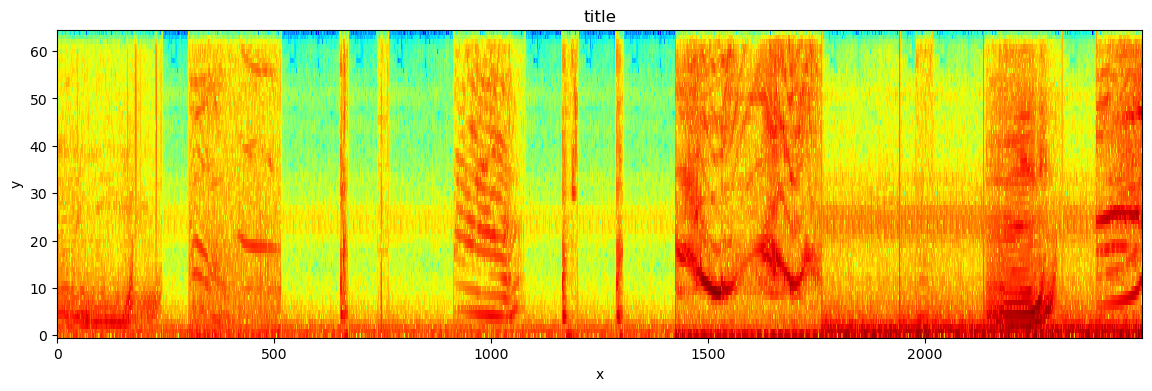

In [86]:
from spafe.utils import vis

# vis.show_features(feats=feature_domain_at_once, title='title', ylabel='y', xlabel='x')
vis.show_features(feats=test_features_concat[12500:15000], title='title', ylabel='y', xlabel='x')

In [ ]:
# train classifier


